#### Importing libraries

In [25]:
import nltk
import pandas as pd
import re
import string
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix

import time
import umap
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Loading the dataset

In [26]:
dataset = pd.read_csv('/kaggle/input/news-dataset/News_Category_Dataset_v3.csv')
df_sampled = dataset.sample(frac=0.5, random_state=42)

#del dataset
df_sampled.info()

df_sampled['category'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 104764 entries, 128310 to 205654
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                104764 non-null  int64 
 1   headline                  104758 non-null  object
 2   category                  104764 non-null  object
 3   short_description         94939 non-null   object
 4   authors                   86080 non-null   object
 5   date                      104764 non-null  object
 6   headline_length           104764 non-null  int64 
 7   short_description_length  104764 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 7.2+ MB


category
POLITICS          17769
WELLNESS           9130
ENTERTAINMENT      8653
TRAVEL             5051
STYLE & BEAUTY     4921
PARENTING          4440
HEALTHY LIVING     3297
QUEER VOICES       3228
FOOD & DRINK       3222
BUSINESS           2997
COMEDY             2660
SPORTS             2515
BLACK VOICES       2320
HOME & LIVING      2189
PARENTS            1976
WEDDINGS           1827
CRIME              1815
THE WORLDPOST      1815
WOMEN              1766
DIVORCE            1714
IMPACT             1704
WORLD NEWS         1603
MEDIA              1495
WEIRD NEWS         1355
RELIGION           1292
WORLDPOST          1283
GREEN              1283
STYLE              1126
SCIENCE            1069
TECH               1051
TASTE              1044
MONEY               876
ARTS                726
ENVIRONMENT         721
GOOD NEWS           691
FIFTY               685
U.S. NEWS           682
ARTS & CULTURE      648
LATINO VOICES       565
COLLEGE             544
CULTURE & ARTS      510
EDUCATI

## 1. Data Preprocessing

#### Converting the data in the columns containing the text to lowercase
** We have considered only the 50% of the dataset due to computational constraints**

In [28]:
df_sampled['short_description'] = df_sampled['short_description'].astype(str).str.lower()
df_sampled['headline'] = df_sampled['headline'].astype(str).str.lower()

#### Function for removing punctuation, standardizing the data and removing the stop words

In [29]:
def preprocess_text_column(text):
    # text = contractions.fix(text)

    punctuation_regex = "[" + re.escape(string.punctuation) + "]"
    text = re.sub(punctuation_regex, ' ', text)
    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'\d+', '', text)

    # spell = Speller(fast=True)
    # text = ' '.join(spell(word) for word in text.split())

    date_formats = [
        r'\b(\d{1,2})[-/](\d{1,2})[-/](\d{2,4})\b',
        r'\b(\d{2,4})[-/](\d{1,2})[-/](\d{1,2})\b',
    ]
    for date_format in date_formats:
        text = re.sub(date_format, lambda x: datetime(*map(int, x.groups())).strftime('%Y-%m-%d'), text)

    # Standardize currency formats
    text = re.sub(r'\$\s?(\d+(?:,\d{3})*(?:\.\d{1,2})?)', lambda x: '${:,.2f}'.format(float(x.group(1).replace(',', ''))), text)

    # Standardize huge numbers
    text = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', text)

    # Standardize decimals
    text = re.sub(r'(\d+),(\d+)', r'\1.\2', text)

    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


#### Function for creating groups for similar categories and giving a common name to the group

In [30]:
categories = df_sampled['category'].value_counts().index

def group_similar_cats(cat_list,name):
    for category in categories:
        if category in cat_list:
            df_sampled.loc[df_sampled['category'] == category, 'category'] = name

#### Executing the grouping function defined above

In [31]:
group_similar_cats( cat_list= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE')

group_similar_cats( cat_list= [ 'PARENTING', 'PARENTS'] , name =  'PARENTING')
group_similar_cats( cat_list= [ 'EDUCATION' ,'COLLEGE'] , name =  'EDUCATION')

group_similar_cats( cat_list= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'ENTERTAINMENT')

group_similar_cats( cat_list= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL & CULTURE')

group_similar_cats( cat_list= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'SUPPORT & WELFARE')

group_similar_cats( cat_list= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS')

group_similar_cats( cat_list= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

group_similar_cats( cat_list= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

group_similar_cats( cat_list= ['TECH', 'SCIENCE'] , name =  'TECHNOLOGY')

group_similar_cats( cat_list= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

group_similar_cats( cat_list= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'OTHER')

#### Displaying categories after grouping

In [32]:
print("Categories after grouping is : ".format(df_sampled['category'].nunique()))
df_sampled['category'].value_counts()

Categories after grouping is : 


category
LIFESTYLE            20663
POLITICS             17769
ENTERTAINMENT        15909
TRAVEL & CULTURE     10475
SUPPORT & WELFARE     7879
PARENTING             6416
OTHER                 6328
GENERAL               4895
WORLDNEWS             4701
BUSINESS              3873
TECHNOLOGY            2120
ENVIRONMENT           2004
EDUCATION             1050
U.S. NEWS              682
Name: count, dtype: int64

In [33]:
print("Timestamp: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
df_sampled['preprocessed_headline'] = df_sampled['headline'].apply(preprocess_text_column)
df_sampled['preprocessed_short_description'] = df_sampled['short_description'].apply(preprocess_text_column)
print("Timestamp: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

Timestamp:  2024-02-20 03:33:19
Timestamp:  2024-02-20 03:33:59


#### TF-IDF vectorization
#### Initializing the TF-IDF vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  transforming text data into a DTM with TF-IDF weighting
TF_IDF_vectorizer = TfidfVectorizer(
     stop_words = 'english',
     max_df=0.85, # remove terms that is present in 85% of the data
     min_df=0.005, # remove infrequent terms (present in only 1% of the data)
)

#### Performing the TF-IDF vectorization

In [35]:
print("Timestamp: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
dtm = TF_IDF_vectorizer.fit_transform(df_sampled['preprocessed_headline'].fillna('') + ' ' + df_sampled['preprocessed_short_description'].fillna(''))
feature_names = TF_IDF_vectorizer.get_feature_names_out()
df_dtm = pd.DataFrame(dtm.toarray(), columns=feature_names)
print(df_dtm.shape)
print("Timestamp: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

print("\nDTM DataFrame Analysis:")
print("Size of the DTM DataFrame:", df_dtm.shape)
print(f"Memory usage of the DTM DataFrame: {df_dtm.memory_usage(deep=True).sum()} bytes")
print("Number of unique terms in DTM:", len(df_dtm.columns))
print("Type of data in DTM DataFrame:", df_dtm.dtypes.unique())

Timestamp:  2024-02-20 03:34:11
(104764, 439)
Timestamp:  2024-02-20 03:34:14

DTM DataFrame Analysis:
Size of the DTM DataFrame: (104764, 439)
Memory usage of the DTM DataFrame: 367931296 bytes
Number of unique terms in DTM: 439
Type of data in DTM DataFrame: [dtype('float64')]


#### Dimensionality Reduction using UMAP

In [44]:
umap_model = umap.UMAP(n_neighbors=200, min_dist=0.5, n_components=10, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(dtm)
X_umap.shape

print("Timestamp: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

## 2. Model Implementation and Evaluation
#### Divide the dataset into training set 75% and testing set 25%

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dtm, df_sampled['category'], test_size=0.25, random_state=42)

### **Logistic Regression (baseline model)**

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# Create a logistic regression model
model = LogisticRegression(max_iter=50, multi_class='multinomial', solver='saga')

# Train the model
model.fit(X_train, y_train)

# Test the model
predictions = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))

#### **Logistic Regression Report (accuracy, precision, recall, and F1-score)**

In [95]:
# Evaluate the model
print(classification_report(y_test, predictions))
cf_matrix_logR = confusion_matrix(y_test, predictions,labels=log_reg_model.classes_)

                   precision    recall  f1-score   support

         BUSINESS       0.35      0.20      0.26       956
        EDUCATION       0.39      0.27      0.32       259
    ENTERTAINMENT       0.40      0.56      0.47      3915
      ENVIRONMENT       0.35      0.15      0.21       530
          GENERAL       0.34      0.15      0.21      1247
        LIFESTYLE       0.51      0.71      0.59      5175
            OTHER       0.67      0.40      0.50      1604
        PARENTING       0.56      0.53      0.54      1634
         POLITICS       0.63      0.72      0.67      4453
SUPPORT & WELFARE       0.48      0.30      0.37      1953
       TECHNOLOGY       0.32      0.06      0.11       542
 TRAVEL & CULTURE       0.50      0.43      0.46      2630
        U.S. NEWS       0.00      0.00      0.00       155
        WORLDNEWS       0.38      0.29      0.33      1138

         accuracy                           0.50     26191
        macro avg       0.42      0.34      0.36     2

#### **Random Forest Classifier**

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the random forest classifier
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf_clf.predict(X_test)

# Evaluate performance
rf_report = classification_report(y_test, rf_pred)



#### **Random Forest Report (accuracy, precision, recall, and F1-score)**

In [42]:
print("Random Forest Report:\n", rf_report)

Random Forest Report:
                    precision    recall  f1-score   support

         BUSINESS       0.33      0.16      0.22       956
        EDUCATION       0.36      0.22      0.27       259
    ENTERTAINMENT       0.38      0.52      0.44      3915
      ENVIRONMENT       0.34      0.13      0.18       530
          GENERAL       0.29      0.11      0.16      1247
        LIFESTYLE       0.51      0.69      0.59      5175
            OTHER       0.69      0.41      0.52      1604
        PARENTING       0.52      0.58      0.55      1634
         POLITICS       0.61      0.73      0.67      4453
SUPPORT & WELFARE       0.45      0.29      0.36      1953
       TECHNOLOGY       0.32      0.07      0.11       542
 TRAVEL & CULTURE       0.46      0.41      0.43      2630
        U.S. NEWS       0.05      0.01      0.01       155
        WORLDNEWS       0.35      0.22      0.27      1138

         accuracy                           0.49     26191
        macro avg       0.40   

#### Using Label Encoder for transforming categorical variables to numeric values for executing XGBoost

In [43]:
from sklearn.preprocessing import LabelEncoder

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(df_sampled['category'])  # Fit on the original category data
encoded_Y_train = encoder.transform(y_train)  # Transform training labels
encoded_Y_test = encoder.transform(y_test)  # Transform test labels

### **XGBoost**

In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize and train the XGBoost classifier with encoded labels
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, encoded_Y_train)

# Predict on the test set using encoded labels
xgb_pred = xgb_clf.predict(X_test)

# Since the predictions are in encoded form, use the inverse_transform method to get back to string labels for evaluation
xgb_pred_labels = encoder.inverse_transform(xgb_pred)
y_test_labels = encoder.inverse_transform(encoded_Y_test)

In [79]:
cf_matrix_xgb = confusion_matrix(encoded_Y_test, xgb_pred,labels=xgb_clf.classes_)

#### **XGBoost Report (accuracy, precision, recall, and F1-score)**

In [45]:
# Evaluate performance
xgb_report = classification_report(y_test_labels, xgb_pred_labels)
print("XGBoost Report:\n", xgb_report)

XGBoost Report:
                    precision    recall  f1-score   support

         BUSINESS       0.38      0.19      0.25       956
        EDUCATION       0.36      0.26      0.30       259
    ENTERTAINMENT       0.36      0.61      0.45      3915
      ENVIRONMENT       0.39      0.15      0.22       530
          GENERAL       0.37      0.12      0.19      1247
        LIFESTYLE       0.53      0.69      0.60      5175
            OTHER       0.71      0.42      0.53      1604
        PARENTING       0.55      0.58      0.56      1634
         POLITICS       0.66      0.72      0.69      4453
SUPPORT & WELFARE       0.49      0.30      0.37      1953
       TECHNOLOGY       0.43      0.07      0.12       542
 TRAVEL & CULTURE       0.54      0.41      0.47      2630
        U.S. NEWS       0.11      0.01      0.02       155
        WORLDNEWS       0.41      0.23      0.30      1138

         accuracy                           0.51     26191
        macro avg       0.45      0.3

### **ARTIFICIAL NEURAL NETWORK (ANN)**

In [46]:
!pip install scikeras

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import time


In [53]:
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(len(y_train.unique()), activation='softmax'))  # Output layer
ann_model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_m_h = ann_model.fit(X_train.toarray(), encoded_Y_train, epochs=20, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/20
492/492 [==============================] - 3s 4ms/step - loss: 1.9415 - accuracy: 0.4011 - val_loss: 1.6717 - val_accuracy: 0.4796
Epoch 2/20
492/492 [==============================] - 2s 4ms/step - loss: 1.6357 - accuracy: 0.4920 - val_loss: 1.6232 - val_accuracy: 0.4942
Epoch 3/20
492/492 [==============================] - 2s 4ms/step - loss: 1.5912 - accuracy: 0.5023 - val_loss: 1.6010 - val_accuracy: 0.5009
Epoch 4/20
492/492 [==============================] - 2s 3ms/step - loss: 1.5643 - accuracy: 0.5074 - val_loss: 1.5920 - val_accuracy: 0.5000
Epoch 5/20
492/492 [==============================] - 2s 3ms/step - loss: 1.5466 - accuracy: 0.5108 - val_loss: 1.5879 - val_accuracy: 0.5005
Epoch 6/20
492/492 [==============================] - 2s 4ms/step - loss: 1.5335 - accuracy: 0.5144 - val_loss: 1.5818 - val_accuracy: 0.5026
Epoch 7/20
492/492 [==============================] - 2s 4ms/step - loss: 1.5219 - accuracy: 0.5175 - val_loss: 1.5806 - val_accuracy: 0.5035
Epoch 

In [57]:
ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), encoded_Y_test)
print(f"ANN Accuracy: {ann_accuracy}")
ann_predicted_values = ann_model.predict(X_test.toarray())
ann_predictions = np.argmax(predicted_values,axis=1)

819/819 [==============================] - 1s 2ms/step - loss: 1.5856 - accuracy: 0.5075
ANN Accuracy: 0.507502555847168
819/819 [==============================] - 1s 1ms/step


#### **ANN Classfication Report (accuracy, precision, recall, and F1-score)**

In [59]:
ann_report = classification_report(encoded_Y_test, predictions)
print("ANN report : \n",ann_report)

ANN report : 
               precision    recall  f1-score   support

           0       0.33      0.22      0.27       956
           1       0.34      0.33      0.34       259
           2       0.39      0.56      0.46      3915
           3       0.38      0.20      0.26       530
           4       0.33      0.21      0.26      1247
           5       0.58      0.63      0.60      5175
           6       0.69      0.42      0.52      1604
           7       0.55      0.58      0.56      1634
           8       0.62      0.74      0.67      4453
           9       0.46      0.33      0.38      1953
          10       0.35      0.08      0.12       542
          11       0.47      0.49      0.48      2630
          12       0.00      0.00      0.00       155
          13       0.38      0.27      0.32      1138

    accuracy                           0.51     26191
   macro avg       0.42      0.36      0.37     26191
weighted avg       0.50      0.51      0.49     26191



In [60]:
ann_m_h.history

{'loss': [1.9414738416671753,
  1.6357089281082153,
  1.59117591381073,
  1.564322590827942,
  1.5465543270111084,
  1.5335131883621216,
  1.5219351053237915,
  1.5119919776916504,
  1.5026323795318604,
  1.4935544729232788,
  1.485775351524353,
  1.4772852659225464,
  1.4688868522644043,
  1.460557460784912,
  1.452621579170227,
  1.4447182416915894,
  1.4366616010665894,
  1.4283920526504517,
  1.4212132692337036,
  1.4136536121368408],
 'accuracy': [0.401094526052475,
  0.49196600914001465,
  0.5022909045219421,
  0.5074294209480286,
  0.510802149772644,
  0.5144293308258057,
  0.5174997448921204,
  0.5194565653800964,
  0.5222405791282654,
  0.5234019756317139,
  0.5261383056640625,
  0.5276814699172974,
  0.5307836532592773,
  0.5332813858985901,
  0.5356994867324829,
  0.5376085638999939,
  0.5405358076095581,
  0.5425562262535095,
  0.5444812178611755,
  0.5476948022842407],
 'val_loss': [1.671733021736145,
  1.6231939792633057,
  1.6009875535964966,
  1.5919878482818604,
  1.58

#### **ANN model accuracy and model loss graph**

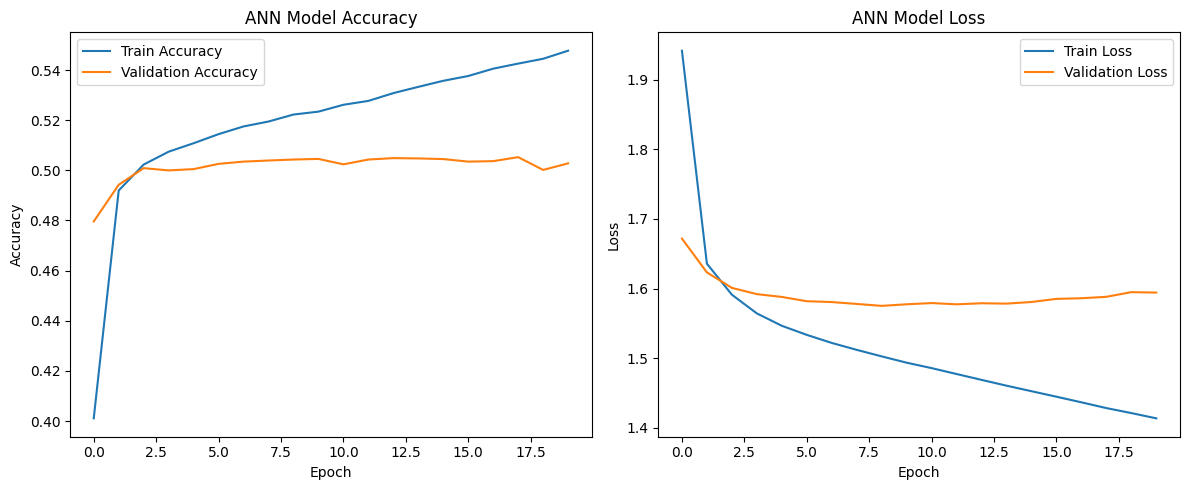

In [63]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ann_m_h.history['accuracy'], label='Train Accuracy')
plt.plot(ann_m_h.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_m_h.history['loss'], label='Train Loss')
plt.plot(ann_m_h.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **CONVOLUTIONAL NEURAL NETWORK (CNN)**

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, Dropout, Flatten, LSTM

In [70]:
cnn_model = Sequential()
#cnn_model.add(Embedding(input_dim=X_train.shape[1], output_dim=128))  # Embedding layer
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(set(encoded_Y_train)), activation='softmax'))
cnn_model.compile(optimizer='RMSProp', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_m_h = cnn_model.fit(X_train.toarray(), encoded_Y_train, epochs=10, batch_size=64, verbose=2, validation_split=0.2)

Epoch 1/10
983/983 - 25s - loss: 1.8195 - accuracy: 0.4316 - val_loss: 1.6492 - val_accuracy: 0.4822 - 25s/epoch - 25ms/step
Epoch 2/10
983/983 - 24s - loss: 1.6598 - accuracy: 0.4838 - val_loss: 1.6217 - val_accuracy: 0.4938 - 24s/epoch - 25ms/step
Epoch 3/10
983/983 - 23s - loss: 1.6296 - accuracy: 0.4928 - val_loss: 1.6132 - val_accuracy: 0.4923 - 23s/epoch - 24ms/step
Epoch 4/10
983/983 - 25s - loss: 1.6070 - accuracy: 0.4969 - val_loss: 1.6111 - val_accuracy: 0.4957 - 25s/epoch - 25ms/step
Epoch 5/10
983/983 - 24s - loss: 1.5978 - accuracy: 0.5017 - val_loss: 1.6063 - val_accuracy: 0.4984 - 24s/epoch - 25ms/step
Epoch 6/10
983/983 - 25s - loss: 1.5872 - accuracy: 0.5045 - val_loss: 1.6080 - val_accuracy: 0.4951 - 25s/epoch - 26ms/step
Epoch 7/10
983/983 - 25s - loss: 1.5815 - accuracy: 0.5069 - val_loss: 1.6478 - val_accuracy: 0.4914 - 25s/epoch - 25ms/step
Epoch 8/10
983/983 - 24s - loss: 1.5780 - accuracy: 0.5063 - val_loss: 1.6056 - val_accuracy: 0.4969 - 24s/epoch - 24ms/step


In [71]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test.toarray(), encoded_Y_test)
print(f"CNN Accuracy: {cnn_accuracy}")
cnn_predicted_values = cnn_model.predict(X_test.toarray())
cnn_predictions = np.argmax(cnn_predicted_values,axis=1)

819/819 [==============================] - 4s 5ms/step - loss: 1.6355 - accuracy: 0.4998
CNN Accuracy: 0.49975183606147766
819/819 [==============================] - 4s 5ms/step


#### **CNN Classfication Report (accuracy, precision, recall, and F1-score)**

In [72]:
cnn_report = classification_report(encoded_Y_test, cnn_predictions)
print("CNN report : \n",cnn_report)

CNN report : 
               precision    recall  f1-score   support

           0       0.37      0.21      0.27       956
           1       0.37      0.28      0.32       259
           2       0.41      0.52      0.46      3915
           3       0.38      0.17      0.23       530
           4       0.30      0.17      0.22      1247
           5       0.53      0.68      0.60      5175
           6       0.62      0.41      0.50      1604
           7       0.50      0.59      0.54      1634
           8       0.58      0.76      0.66      4453
           9       0.44      0.30      0.36      1953
          10       0.45      0.06      0.11       542
          11       0.52      0.40      0.46      2630
          12       0.00      0.00      0.00       155
          13       0.44      0.21      0.28      1138

    accuracy                           0.50     26191
   macro avg       0.42      0.34      0.36     26191
weighted avg       0.49      0.50      0.48     26191



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
cnn_m_h.history['val_accuracy']

[0.48221445083618164,
 0.4937957227230072,
 0.4923321604728699,
 0.4957047402858734,
 0.4984409809112549,
 0.4951320290565491,
 0.49137765169143677,
 0.4969137907028198,
 0.4943048059940338,
 0.49506840109825134]

## 3. Comparative Analysis

#### Conventional ML Techniques vs Deep learning

Logistic regression is often used for linear relationships and binary classification tasks. It might grapple with scenarios of non-linear relationaships and patterns.It has significantly low computational complexity and model interpretability is very high compared to DL. We observed in our case that Deep learning and conventional ML techniques perform very similarly, but LSTM (RNN) had a very good improvement in accuracy but is very computationally intensive.So we can conclude that Deep Learning out performs conventional ML techniques with a trade-off of high computational complexity and lower model interpretability.In our case, conventional ML techniques(Tree ensemble methods) consumed more time for execution and DL techniques consumed more computational resources.

Comprehending the reasoning behind specific predictions made by complex deep learning models, especially those with convoluted and tangled structures is challenging, furnishing them as "black boxes." Tree-ensemble models such as the XGBoost and RandomForest are generally well suited for structured and tabular data, several studies have shown that Tree-ensemble methods such as XGBoost performs similar to and in certain cases outperforms deep learning methods, learns quickly than DL methods for structured/tabular data. https://medium.com/latinxinai/do-you-really-need-deep-learning-84d1a8629ed6. Tree ensemble methods are definitely more interpretable than DL techniques.When it comes to high dimensional and unstructured complex data formats such as images etc, Deep learning is the way to go.


To summarize, deep learning has definitely revolutionized tasks with non-tabular data, they perform very similar or at times even underperform the conventional machine learning models when dealing with tabular data. The absence of a universal standard model in the industry emphasizes the importance of continuous testing, fine-tuning, and validation in the iterative process of finding the most effective solution for specific problems which is also influenced by the availability of computational resources. We need to explore various methodologies to determine the most optimal approach for the specific needs of the given problem.


#### **CONFUSION MATRIX FOR LOGISTIC REGRESSION**

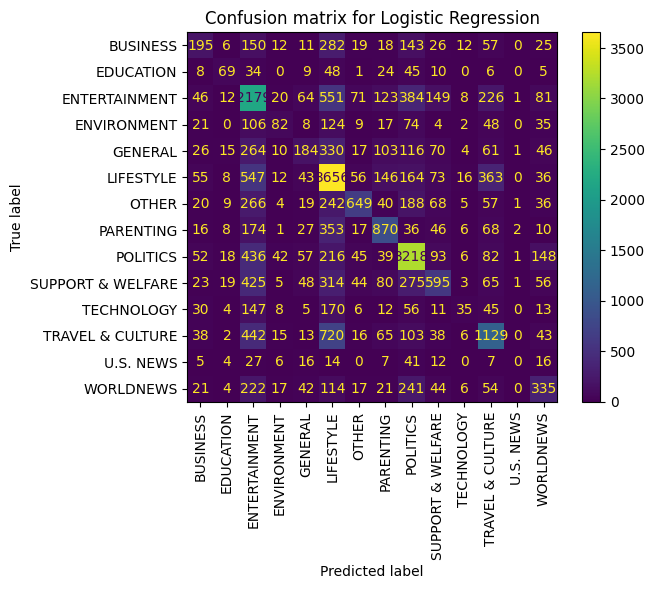

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_logR,display_labels=log_reg_model.classes_)
disp.plot(xticks_rotation = 'vertical')
plt.title('Confusion matrix for Logistic Regression')
plt.show()

#### **CONFUSION MATRIX FOR RANDOM FOREST**

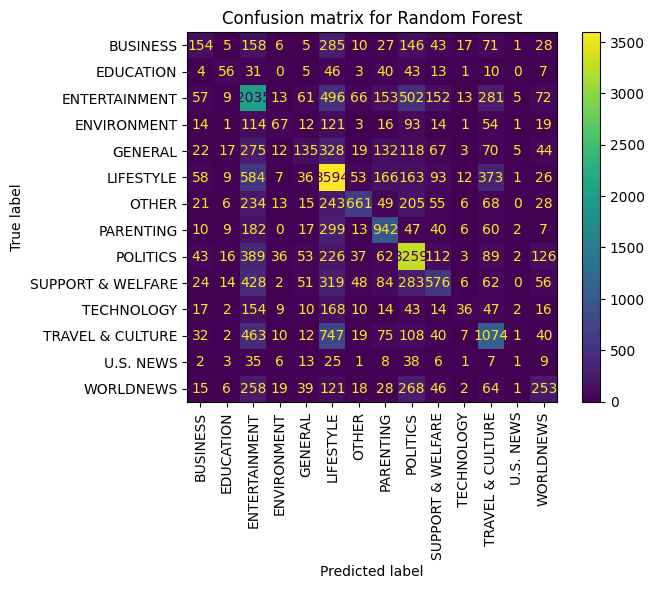

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
cf_matrix_rf = confusion_matrix(y_test, rf_pred,labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_rf,display_labels=rf_clf.classes_)
disp.plot(xticks_rotation = 'vertical')
plt.title('Confusion matrix for Random Forest')
plt.show()

#### **CONFUSION MATRIX FOR XGBOOST**

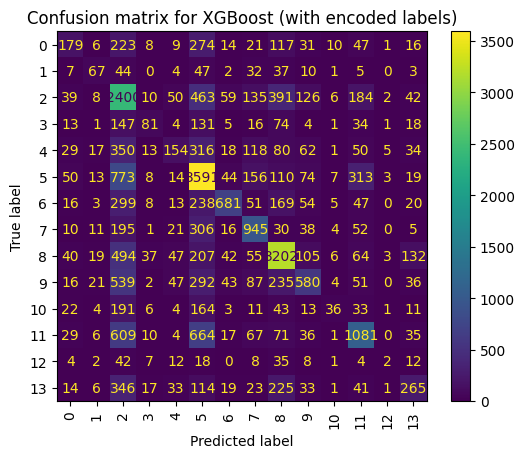

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_xgb,display_labels=xgb_clf.classes_)
disp.plot(xticks_rotation = 'vertical')
plt.title('Confusion matrix for XGBoost (with encoded labels)')
plt.show()

#### **CONFUSION MATRIX FOR ANN**

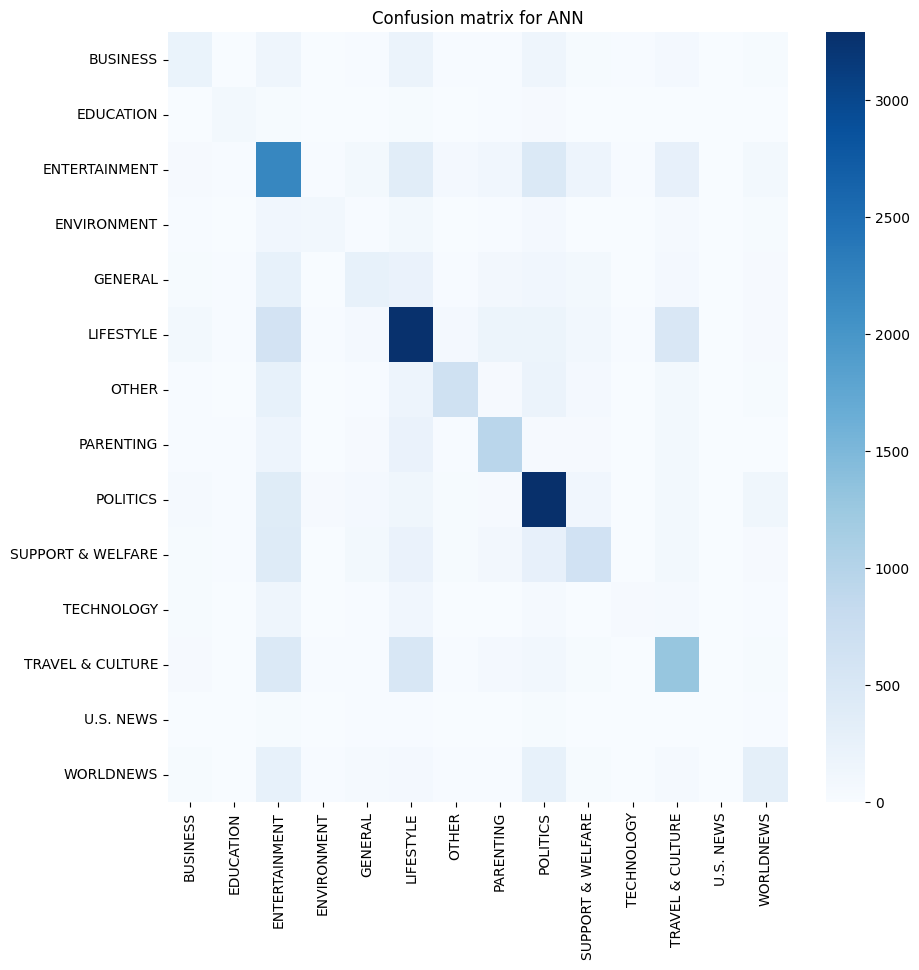

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
cf_matrix_ann = confusion_matrix(encoded_Y_test, ann_predictions)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_ann)
sns.heatmap(cf_matrix_ann,fmt='d',cmap='Blues',xticklabels =np.unique(df_sampled['category']),yticklabels=np.unique(df_sampled['category']) )
plt.title('Confusion matrix for ANN')
plt.show()

#### **CONFUSION MATRIX FOR CNN**

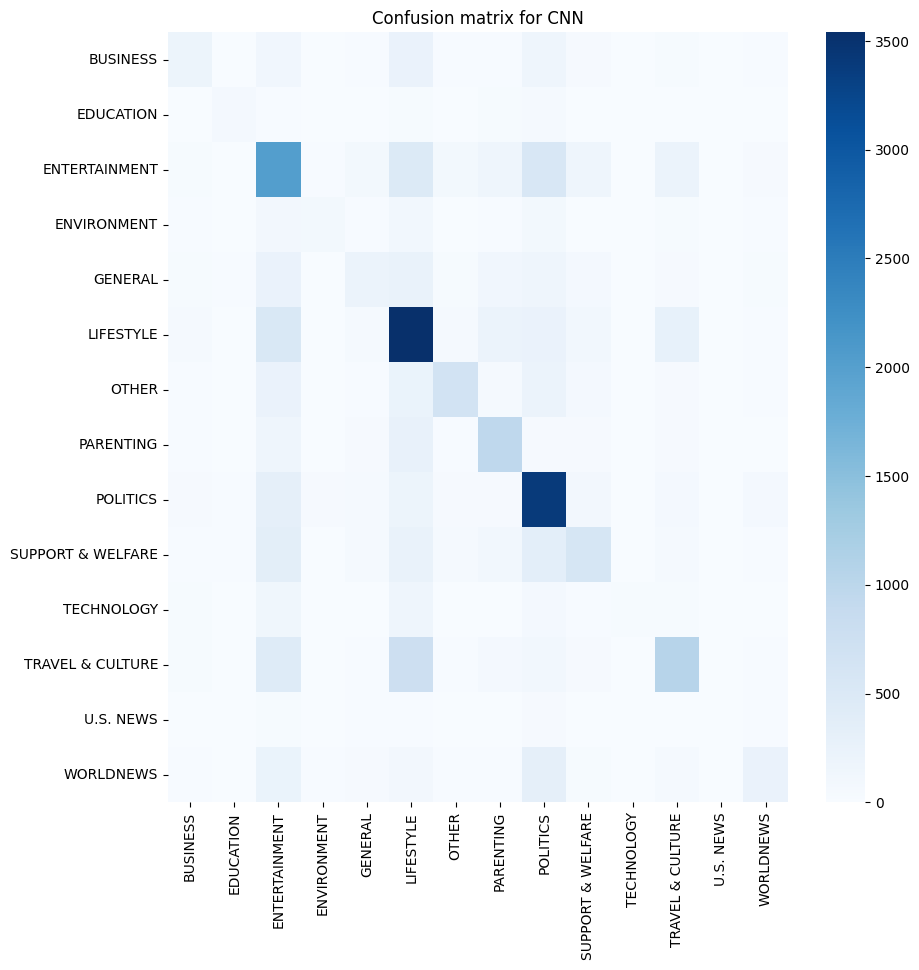

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
cf_matrix_cnn = confusion_matrix(encoded_Y_test, cnn_predictions)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_cnn)
sns.heatmap(cf_matrix_cnn,fmt='d',cmap='Blues',xticklabels =np.unique(df_sampled['category']),yticklabels=np.unique(df_sampled['category']) )
plt.title('Confusion matrix for CNN')
plt.show()

### **4. DISCUSSION**

In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ann_m_h.history['accuracy'], label='Train Accuracy')
plt.plot(ann_m_h.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_m_h.history['loss'], label='Train Loss')
plt.plot(ann_m_h.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Logistic Regression**

Initially, we got an avg accuracy of 42% when we executed Logistic regression with 'saga' solver with 50% of the original dataset. After playing around wit LogisticRegression function we understood that not all types solvers support multi class classification. 

After few trial and errors, we decided to choose saga solver. To improve the accuracy we added regularization parameter - penalty parameter. l1 regularization did not make much of a difference but 'l2' did improve the accuracy slightly but not very significantly. Then we added the C parameter which controls the strength of regularization and noticed that as we decreasing the C value to 0.01 deteriorated the accuracy even more and we got an accuracy of 35%. Then we chaged it to 0.5 , which brought the accuracy back to 42%. Increasing the C value greater than 0.5 did not make much of a difference. So we were stuck with accuracy of 42%. 

 We also constructed the confusion matrix and observed that similar categories had very high values.
 So we iterated a step back to Data preprocessing and decided to group similar categories under one   common category. After executing logistic regression with this update accuracy improved to 51%.
 


**Random Forest Classifier**

As in the case of Logistic regression, after grouping similar categories under one common label the accuracy improved by 13%. We experimented with several hyperparameters here as well. For the hypermeter of criterion we tried executing with 'gini; and 'entropy'. This did not change the performance at all.
Then for max_features hyperparameters we tried using the log2 and also setting this to 'None' to consider all the features, there wasnt any significant improvement in accuracy. We tried with sqrt as well, which is the default parameter, the accuracy remained same. We also adjusted the hyperparameters such as min_impurity_decrease,max_leaf_nodes the accuracy did not go beyond 52%.

After this step we also tried to use the entire dataset to see if more training data might lead to better performance, but even feeding more data did not seem to improve the accuracy.We tried to set bootstrap hyperparameter to false, the accuracy improved very slightly bu 0.3%.


**XGBoost**

We decided to try with both Label Encoder and One-hot encoder. Implementing one-hot encoder was a bit challenging. We tried with both the encoding techniques and found that the performance was almost similar. XGBoost executed with one-hot encoder was 1% more accurate. But we decided to go with label-encoder as we found it more interpretable.

**ANN**

Performance of the model was shown to be around 40% initially for ANN. After observing the ANN model accuracy and the Model loss graph. We could see that there was overfitting.We tried to decrease the units for two of the Dense layers in the model, added extra dense layer and also adjusted the activation functions, the avg accuracy improved to almost 50%.

We also tried to include more dataset, initially we used only 50% original dataset both for with a split of 75% training and 25% testing (with a thought that giving more diversified data may prevent the 
overfit) for training, but it did not improve the accuracy, indicating that the other 50% of the dataset contains similar data. So training with more data did not help.

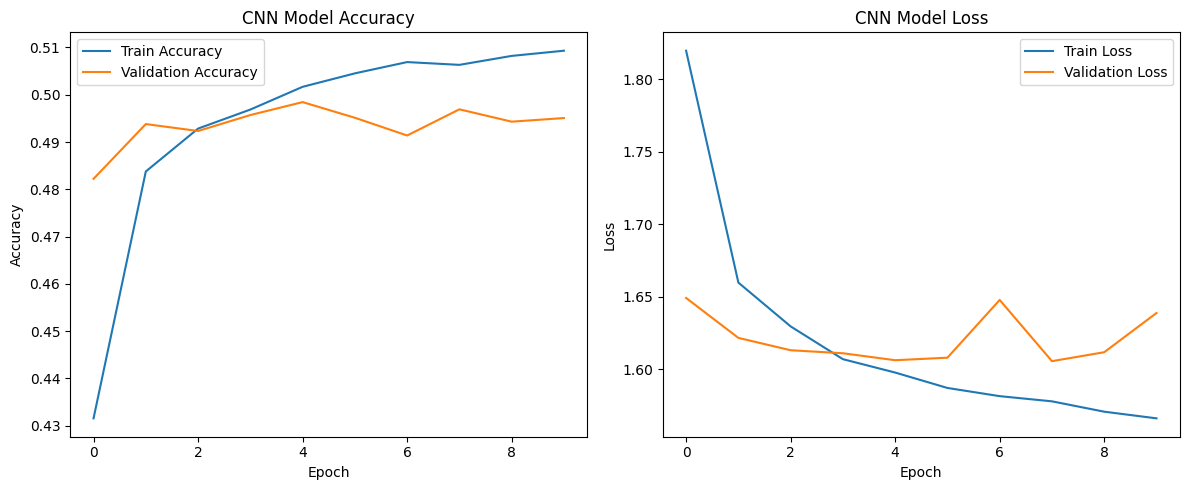

In [97]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_m_h.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_m_h.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_m_h.history['loss'], label='Train Loss')
plt.plot(cnn_m_h.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**CNN**

Performance of the model was shown to be around 42% initially for CNN. After observing the CNN model 
accuracy and the Model loss graph. We could see that there was overfitting.We tried to decrease the units for two of the Dense layers in the model and added an additional dropout layer and increased the dropout values in the layer to 0.3. This led to an increase in accuracy to 50%. We also tried to include more dataset, initially we used only 50% of the original dataset both for
with a split of 75% training and 25% testing (with a thought that giving more diversified data may prevent the overfit) for training, this slightly increased the accuracy to 52% which is not very significant, indicating that the other 50% of the dataset contains similar data. So training with more data did not help much as in case of ANN.

**Importance of preprocessing and feature engineering**

Preprocessing and feature engineering play a crucial role in text classification tasks as they convert raw text data into a format compatible with machine learning models. These steps are essential for minimizing noise, extracting meaningful information, and enhancing the model's capability to generalize and make accurate predictions. A meticulous approach to preprocessing and feature engineering can profoundly influence the overall effectiveness of text classification models.

As explained previously, grouping similar categories into a single category label drastically improved the accuracy by more than 15% in our case. This fact very effectively proves the importance of data preprocessing and feature engineering.